In [1]:
import numpy as np
import time
from math import sqrt, pi, exp
import functools
import scipy
import matplotlib.pylab as pl
from varname import nameof


from utils.preconditioners import *
from utils.algorithms import * 
from utils.plot_functions import *
from utils.mog_functions import *

import seaborn as sns

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


import jax
import jax.numpy as jnp
import scipy.linalg
from alive_progress import alive_bar

matplotlib.rcParams.update({'font.size': 18})


### Test case "Gaussian"

In [2]:
# Dimension
d = 2

# Observed data (dimension 1)
y = jnp.zeros(1)

# Grid boundaries
xmin, xmax = -5, 5
ymin, ymax = -5, 5

# Noise levels
sigNoise = 1.0
sigPrior = 1

# Define JAX-compatible function G
#def G(u):
#    return (u[0] - 1) + (u[1] + 1)**2   # Model function
def G(u):
    return jnp.array([(u[0] - 1) + (u[1] + 1)**2]).reshape(-1, 1)  # Shape (obs_dim, 1)
    #return jnp.array([(u[0] - 1)*(u[1] + 1)]).reshape(-1, 1)  # Shape (obs_dim, 1)

# Define likelihood term
def Phi(u):
    return 0.5 / (sigNoise**2) * (G(u) - y) ** 2

# Define posterior potential function V(u), ensuring scalar output
def V(u):
    return jnp.squeeze(0.5 / (sigPrior**2) * jnp.sum(u**2) + Phi(u))

# Compute gradient using JAX automatic differentiation
grad_V = jit(grad(V))  # JIT compilation for speed

# Compute Jacobian of G using JAX's `jacfwd`
J_G = jit(jacfwd(G))  # Forward-mode differentiation

# Compute posterior covariance matrix
@jit
def compute_posterior_covariance():
    u_ref = jnp.zeros(d)  # Reference point (e.g., prior mean)
    g = J_G(u_ref).reshape(1, d)  # Ensure correct shape

    # Compute posterior inverse covariance matrix using Bayesian update rule
    K_inv = jnp.eye(d) * (1 / sigPrior**2) + (1 / sigNoise**2) * g.T @ g
    K = jnp.linalg.inv(K_inv)  # Compute posterior covariance

    return K, K_inv

K, K_inv = compute_posterior_covariance()

print("Posterior Covariance Matrix (K):\n", K)
print("\nInverse Posterior Covariance Matrix (K_inv):\n", K_inv)


Posterior Covariance Matrix (K):
 [[ 0.8333334  -0.33333334]
 [-0.33333334  0.33333334]]

Inverse Posterior Covariance Matrix (K_inv):
 [[2. 2.]
 [2. 5.]]


[0. 0.]


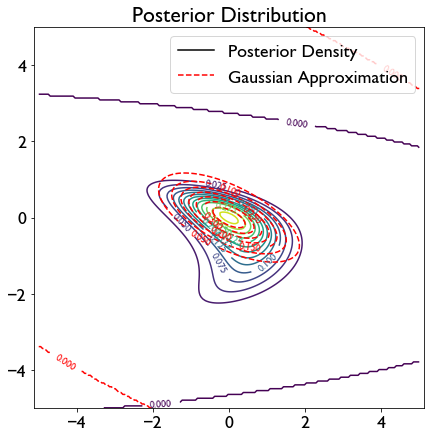

In [3]:

# Grid setup
nb_grid = 200
u0s = jnp.linspace(xmin, xmax, nb_grid)
u1s = jnp.linspace(ymin, ymax, nb_grid)
U0, U1 = jnp.meshgrid(u0s, u1s, indexing="ij")
U = jnp.stack([U0.ravel(), U1.ravel()], axis=1)  # Shape (nb_grid², 2)

# ✅ **JIT-compiled evaluation of `V`**
@jax.jit
def eval_V(U):
    return jax.vmap(V)(U)  # Vectorized evaluation over all points

# ✅ **Compute posterior density efficiently**
unnorm_dens = jnp.exp(-eval_V(U)).reshape(nb_grid, nb_grid)

# ✅ **Precompute normalization constant only once**
Z = jnp.trapz(jnp.trapz(unnorm_dens, u0s, axis=0), u1s)
dens = unnorm_dens / Z  # Normalized density

# ✅ **Compute marginal distributions in one pass**
marg_over_x = jnp.trapz(dens, u1s, axis=1)
marg_over_y = jnp.trapz(dens, u0s, axis=0)

# ✅ **Precompute Gaussian approximation terms**
# ✅ Compute the posterior mean
u_ref = jnp.zeros(d)  # Prior mean reference point
J_G_ref = J_G(u_ref).reshape(1, d)  # Jacobian at prior mean
m_post = K @ (J_G_ref.T @ y)  # Posterior mean formula

# ✅ Replace `m` with the computed posterior mean
m = m_post.flatten()
print(m)

cov_inv = jnp.linalg.inv(K)
cov_det = jnp.linalg.det(K)
norm_coeff = 1.0 / jnp.sqrt((2 * jnp.pi) ** d * cov_det)

# ✅ **Compute Gaussian posterior efficiently using einsum**
T = norm_coeff * jnp.exp(
    -0.5 * jnp.einsum("ij,ij->i", U - m, (U - m) @ cov_inv)
).reshape(nb_grid, nb_grid)

# ✅ **Plot posterior density contours**
plt.figure(figsize=(7, 7))
DS = plt.contour(U0, U1, dens, levels=15, cmap="viridis")  # No label here
plt.clabel(DS, inline=1, fontsize=10)

# ✅ **Plot Gaussian approximation**
CS = plt.contour(U0, U1, T, linestyles="--", colors="red")  # No label here
plt.clabel(CS, inline=1, fontsize=10)

# ✅ **Manually create a legend**
legend_elements = [
    Line2D([0], [0], color="black", linestyle="-", label="Posterior Density"),
    Line2D([0], [0], color="red", linestyle="--", label="Gaussian Approximation")
]
plt.legend(handles=legend_elements, loc="upper right")

plt.axis("equal")
plt.title("Posterior Distribution")
plt.show()


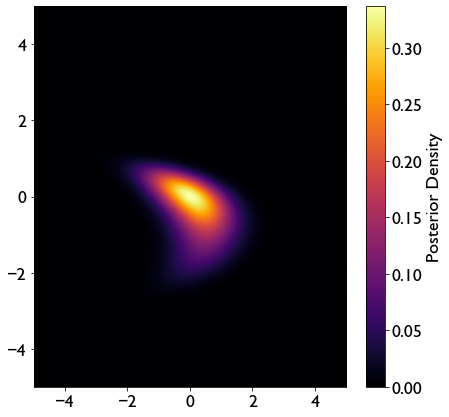

In [4]:
# ✅ Plot heatmap of posterior density
plt.figure(figsize=(7, 7))
plt.imshow(dens.T, origin="lower", extent=[xmin, xmax, ymin, ymax], aspect="auto", cmap="inferno")
plt.colorbar(label="Posterior Density")

### Try algorithms

In [5]:
# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations #### TO CHANGE
d = 2 # dimension
tau = 1e-3 # step size

mean_init = np.asarray([5, 7])
cov_init = [[1, 0], [0, 2]]

# parameters of our algorithm
const = 10 

# number of experiments
N_exp = 1

   
# initialization
u0 = np.random.multivariate_normal(mean_init, cov_init, J).T
    
# for plots 
val = 6


### with true gradients

|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 4.0s (251.96/s▆▄▂ 695/1000 [70%] in 3s (~1s, 239.3/
(2, 20, 1000)


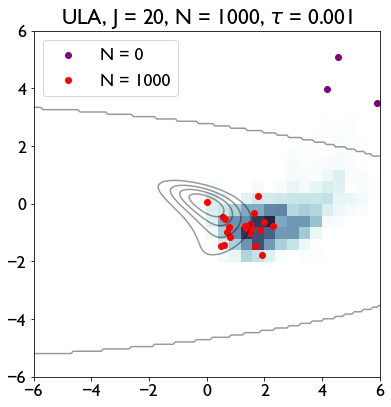

|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 4.6s (219.63/s▄▆█ 200/1000 [20%] in 1s (~4s, 192.3/ ▄▆█ 354/1000 [35%] in 2s (~3s, 207.6/(~2s, 217.5/


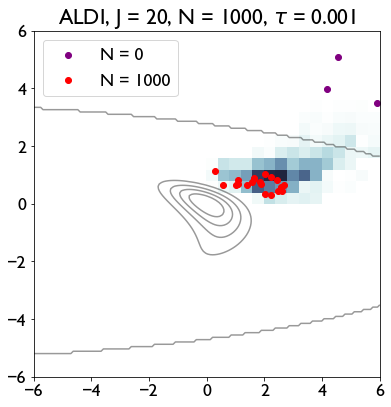

on 0: /opt/anaconda3/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32. In future JAX releases this will result in an error.
        warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/opt/anaconda3/lib/python3.8/site-packages/jax/_src/ops/scatter.py:127: ComplexWarning: Casting complex values to real discards the imaginary part
        return lax_internal._convert_element_type(out, dtype, weak_type)


|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 5.8s (174.00/s


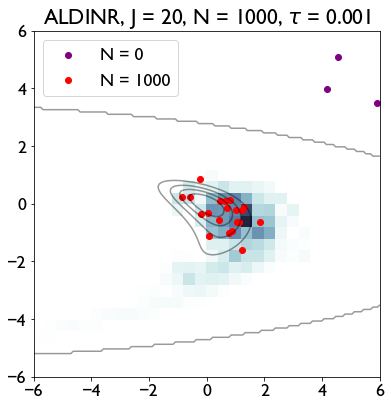

In [6]:
target_potential_jax = lambda z: V(z)
import numpy as np

#target_potential = lambda u: 

def plot_results(potential, us_list, tau, name, N_burnin=0, xmin=-2, xmax=2, ymin=-2, ymax=2):
    plt.figure(figsize=(6, 6))

    # ✅ **Vectorized potential evaluation using JAX vmap**
    @jax.jit
    def potential_vectorized(U):
        return jax.vmap(potential)(U)  # Apply potential to entire array at once

    # Grid setup
    u0s = jnp.linspace(xmin, xmax, 150)
    u1s = jnp.linspace(ymin, ymax, 150)
    U0, U1 = jnp.meshgrid(u0s, u1s, indexing="ij")
    U = jnp.stack([U0.ravel(), U1.ravel()], axis=1)  # Shape (num_points, 2)

    # ✅ **Fast potential evaluation**
    Z = potential_vectorized(U).reshape(150, 150)

    # ✅ **Fast histogram computation**
    binsx = jnp.linspace(xmin, xmax, 31)
    binsy = jnp.linspace(ymin, ymax, 31)
    H, _, _ = np.histogram2d(
        us_list[0, :, N_burnin:].ravel(),
        us_list[1, :, N_burnin:].ravel(),
        bins=[binsx, binsy]
    )

    # Heatmap plot
    cmap = sns.cubehelix_palette(start=0, rot=-0.2, light=1, as_cmap=True)
    plt.pcolormesh(binsx, binsy, H.T, cmap=cmap)

    # ✅ **Contour plot (avoiding unnecessary computations)**
    plt.contour(U0, U1, jnp.exp(-Z), levels=5, alpha=0.4, colors="black")

    # Plot initial and final positions
    J, N_sim = us_list.shape[1], us_list.shape[2]
    plt.scatter(us_list[0, :, 0], us_list[1, :, 0], color="purple", label="N = 0")
    plt.scatter(us_list[0, :, -1], us_list[1, :, -1], color="red", label=f"N = {N_sim}")

    plt.title(f"{name}, J = {J}, N = {N_sim}, $\\tau$ = {tau}")
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.tight_layout()
    plt.show()



for j in range(N_exp):
    
    # ULA, ALDI and NRALDI with jax gradient formula 
    
    us_list_ULA = run_ULA(target_potential_jax, N_sim, u0, tau)
    print(us_list_ULA.shape)
    name = nameof(us_list_ULA).lstrip('us_list')    
    plot_results(target_potential_jax, us_list_ULA, tau, name, xmin=-val, xmax=val, ymin=-val, ymax=val)
    
    us_list_ALDI = run_ALDI(target_potential_jax, N_sim, u0, tau)
    name = nameof(us_list_ALDI).lstrip('us_list')    
    plot_results(target_potential_jax, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    
    
    us_list_ALDINR = run_ALDINR(target_potential_jax, N_sim, u0, tau,  const)
    name = nameof(us_list_ALDINR).lstrip('us_list')    
    plot_results(target_potential_jax, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)


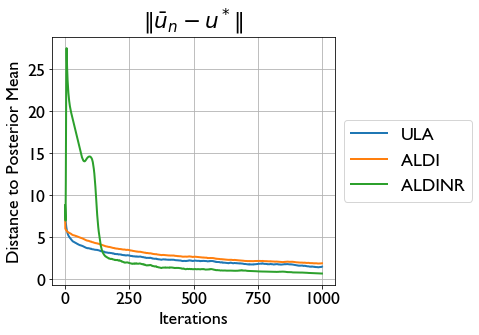

In [7]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# ✅ JIT-compiled mean computation with JAX
@jax.jit
def compute_mean_jax(iterates):
    return jnp.mean(iterates, axis=1)  # Computes mean along particles dimension

# ✅ Compute means for each algorithm
means_ULA = compute_mean_jax(us_list_ULA)
means_ALDI = compute_mean_jax(us_list_ALDI)
means_ALDINR = compute_mean_jax(us_list_ALDINR)

# ✅ Compute distances to posterior mean
posterior_mean = m_post.flatten().reshape(2, 1)  # Ensure shape is (2, 1)

@jax.jit
def compute_distance_jax(means, ref_mean):
    return jnp.linalg.norm(means - ref_mean, axis=0)  # Compute norm along correct axis

distances_to_mean_ULA = compute_distance_jax(means_ULA, posterior_mean)
distances_to_mean_ALDI = compute_distance_jax(means_ALDI, posterior_mean)
distances_to_mean_ALDINR = compute_distance_jax(means_ALDINR, posterior_mean)

# ✅ Plot results
plt.figure(figsize=(7, 5))
plt.plot(distances_to_mean_ULA, label="ULA", linewidth=2)
plt.plot(distances_to_mean_ALDI, label="ALDI", linewidth=2)
plt.plot(distances_to_mean_ALDINR, label="ALDINR", linewidth=2)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title(r'$\Vert \bar{u}_n - u^*\Vert$')
plt.xlabel("Iterations")
plt.ylabel("Distance to Posterior Mean")
plt.grid(True)
plt.tight_layout()
plt.show()


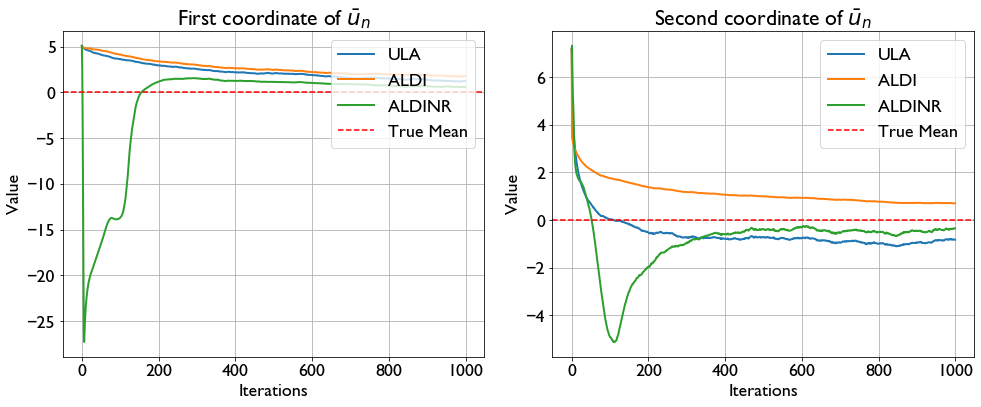

In [8]:
import matplotlib.pyplot as plt

# ✅ Create figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# ✅ First coordinate plot
axes[0].plot(means_ULA[0, :], label="ULA", linewidth=2)
axes[0].plot(means_ALDI[0, :], label="ALDI", linewidth=2)
axes[0].plot(means_ALDINR[0, :], label="ALDINR", linewidth=2)
axes[0].axhline(y=posterior_mean[0], color='r', linestyle='--', label='True Mean')  # Use correct posterior mean
axes[0].set_title(r'First coordinate of $\bar{u}_n$')
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("Value")
axes[0].legend(loc="upper right")
axes[0].grid(True)

# ✅ Second coordinate plot
axes[1].plot(means_ULA[1, :], label="ULA", linewidth=2)
axes[1].plot(means_ALDI[1, :], label="ALDI", linewidth=2)
axes[1].plot(means_ALDINR[1, :], label="ALDINR", linewidth=2)
axes[1].axhline(y=posterior_mean[1], color='r', linestyle='--', label='True Mean')  # Use correct posterior mean
axes[1].set_title(r'Second coordinate of $\bar{u}_n$')
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("Value")
axes[1].legend(loc="upper right")
axes[1].grid(True)

# ✅ Improve layout
plt.tight_layout()
plt.show()


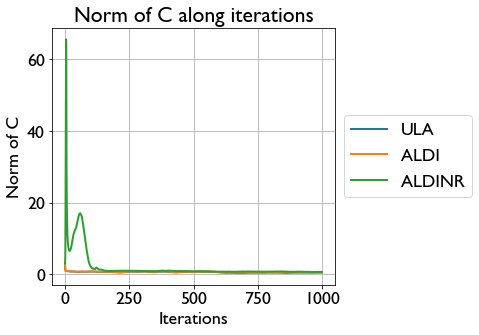

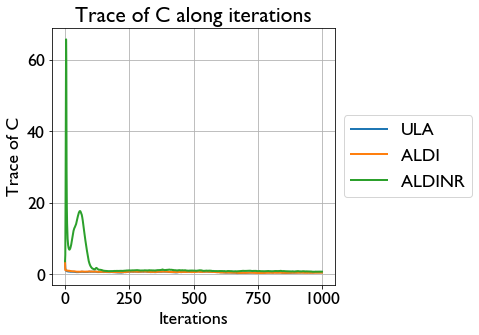

In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# ✅ JIT-compiled norm computation
@jax.jit
def compute_norm_jax(covariances):
    return jnp.linalg.norm(covariances, axis=(0, 1))  # Compute norms along the first two axes

# ✅ JIT-compiled trace computation
@jax.jit
def compute_trace_jax(covariances):
    return jnp.trace(covariances, axis1=0, axis2=1)  # Compute trace along correct axes

covariances_ULA = compute_covariances(us_list_ULA)
covariances_ALDI = compute_covariances(us_list_ALDI)
covariances_ALDINR = compute_covariances(us_list_ALDINR)

# ✅ Compute norm of C for each algorithm
distances_to_covariances_ULA = compute_norm_jax(covariances_ULA)
distances_to_covariances_ALDI = compute_norm_jax(covariances_ALDI)
distances_to_covariances_ALDINR = compute_norm_jax(covariances_ALDINR)

# ✅ Compute trace of C for each algorithm
traces_of_C_ULA = compute_trace_jax(covariances_ULA)
traces_of_C_ALDI = compute_trace_jax(covariances_ALDI)
traces_of_C_ALDINR = compute_trace_jax(covariances_ALDINR)

# ✅ Plot norm of C over iterations
plt.figure(figsize=(7, 5))
plt.plot(distances_to_covariances_ULA, label="ULA", linewidth=2)
plt.plot(distances_to_covariances_ALDI, label="ALDI", linewidth=2)
plt.plot(distances_to_covariances_ALDINR, label="ALDINR", linewidth=2)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Norm of C along iterations")
plt.xlabel("Iterations")
plt.ylabel("Norm of C")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Plot trace of C over iterations
plt.figure(figsize=(7, 5))
plt.plot(traces_of_C_ULA, label="ULA", linewidth=2)
plt.plot(traces_of_C_ALDI, label="ALDI", linewidth=2)
plt.plot(traces_of_C_ALDINR, label="ALDINR", linewidth=2)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Trace of C along iterations")
plt.xlabel("Iterations")
plt.ylabel("Trace of C")
plt.grid(True)
plt.tight_layout()
plt.show()


### with statistical linearization

|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 43.4s (22.83/s67/1000 [17%] in 4s (~20s, 42.5/ ▃▁▃ 330/1000 [33%] in 8s (~16s, 40.7/in 14s (~18s, 31.7▃▅▇ 441/1000 [44%] in 16s (~19s, 28.9 442/1000 [44%] in 16s (~19s, 28.4 444/1000 [44%] in 18s (~22s, 25.4▂▄▆ 444/1000 [44%] in 18s (~22s, 25.0444/1000 [44%] in 19s (~22s, 24.6 445/1000 [44%] in 19s (~23s, 24.3 ▇▇▅ 446/1000 [45%] in 20s (~24s, 23.2▅▃▁ 446/1000 [45%] in 21s (~25s, 22.1(~25s, 21.6 ▂▂▄ 447/1000 [45%] in 22s (~26s, 21.4 ▁▃▅ 447/1000 [45%] in 22s (~26s, 21.1in 22s (~26s, 20.9 448/1000 [45%] in 22s (~26s, 20.6448/1000 [45%] in 23s (~27s, 20.2 ▇▇▅ 448/1000 [45%] in 23s (~28s, 19.8449/1000 [45%] in 24s (~28s, 19.3 ▃▁▃ 450/1000 [45%] in 26s (~30s, 18.1▁▃▅ 450/1000 [45%] in 26s (~31s, 17.6in 27s (~32s, 16.9451/1000 [45%] in 28s (~33s, 16.5 451/1000 [45%] in 28s (~33s, 16.3 ▆▄▂ 517/1000 [52%] in 33s (~32s, 15.4 ▄▂▂ 522/1000 [52%] in 34s (~31s, 15.4


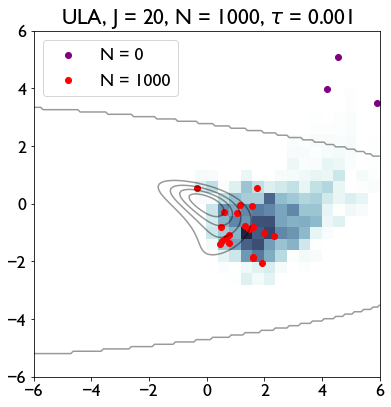

|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 18.1s (55.07/sn 2s (~19s, 46.6/s ▄▂▂ 818/1000 [82%] in 15s (~3s, 54.8/ █▆▄ 854/1000 [85%] in 16s (~3s, 54.9/


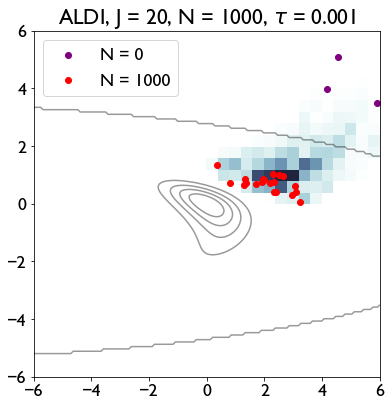

on 0: /opt/anaconda3/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32. In future JAX releases this will result in an error.
        warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/opt/anaconda3/lib/python3.8/site-packages/jax/_src/ops/scatter.py:127: ComplexWarning: Casting complex values to real discards the imaginary part
        return lax_internal._convert_element_type(out, dtype, weak_type)


|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 11.0s (91.10/s


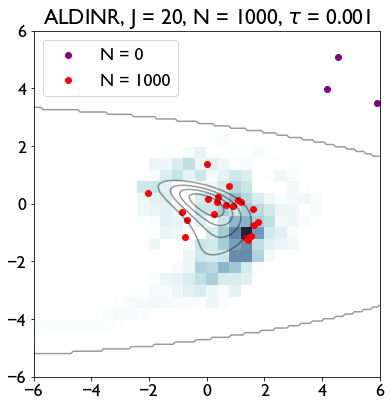

In [10]:
for j in range(N_exp):
    
    # ULA, ALDI and NRALDI with statistical linearization
    us_list_ULA = run_ULA_SL(G, y, N_sim, u0, tau)
    name = nameof(us_list_ULA).lstrip('us_list')    
    plot_results(target_potential_jax, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    

    us_list_ALDI = run_ALDI_SL(G, y, N_sim, u0, tau)
    name = nameof(us_list_ALDI).lstrip('us_list')    
    plot_results(target_potential_jax, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    
    
    us_list_ALDINR = run_ALDINR_SL(G, y, N_sim, u0, tau, const)
    name = nameof(us_list_ALDINR).lstrip('us_list')    
    plot_results(target_potential_jax, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    
    


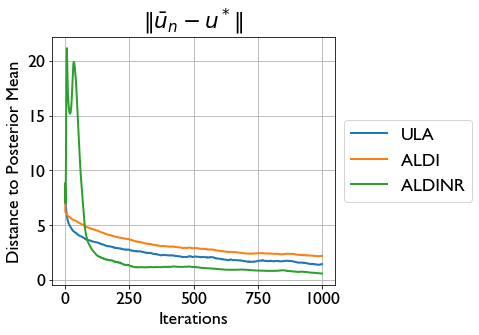

In [11]:
# ✅ JIT-compiled mean computation with JAX
@jax.jit
def compute_mean_jax(iterates):
    return jnp.mean(iterates, axis=1)  # Computes mean along particles dimension

# ✅ Compute means for each algorithm
means_ULA = compute_mean_jax(us_list_ULA)
means_ALDI = compute_mean_jax(us_list_ALDI)
means_ALDINR = compute_mean_jax(us_list_ALDINR)

# ✅ Compute distances to posterior mean
posterior_mean = m_post.flatten().reshape(2, 1)  # Ensure shape is (2, 1)

@jax.jit
def compute_distance_jax(means, ref_mean):
    return jnp.linalg.norm(means - ref_mean, axis=0)  # Compute norm along correct axis

distances_to_mean_ULA = compute_distance_jax(means_ULA, posterior_mean)
distances_to_mean_ALDI = compute_distance_jax(means_ALDI, posterior_mean)
distances_to_mean_ALDINR = compute_distance_jax(means_ALDINR, posterior_mean)

# ✅ Plot results
plt.figure(figsize=(7, 5))
plt.plot(distances_to_mean_ULA, label="ULA", linewidth=2)
plt.plot(distances_to_mean_ALDI, label="ALDI", linewidth=2)
plt.plot(distances_to_mean_ALDINR, label="ALDINR", linewidth=2)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title(r'$\Vert \bar{u}_n - u^*\Vert$')
plt.xlabel("Iterations")
plt.ylabel("Distance to Posterior Mean")
plt.grid(True)
plt.tight_layout()
plt.show()
